<a href="https://colab.research.google.com/github/ArtemBurenok/genetic_algorithms/blob/main/symbolic_regression_polinoms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyglyph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11937 sha256=fe2f110e8e6227c6a5816446f5aeba4509c23084076083cd1ff328af48a47b70
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
  Created wheel for sqlitedict: filename=sqlitedict-2.1.0-py3-none-any.whl size=16863 sha256=39c6fc7dcdaf768ae50ac463480bcaa922d0bfdd61f3fd0759c842c69b964885
  Stored in directory: /root/.cache/pip/wheels/79/d6/e7/304e0e6cb2221022c26d8161f7c23cd4f259a9e41e8bbcfabd
Successfully built stopit sqlitedict


In [ ]:
from functools import partial

import deap.gp
import deap.tools
import numpy as np

from glyph import gp
from glyph.assessment import const_opt
from glyph.utils import Memoize
from glyph.utils.numeric import nrmse, silent_numpy
import pandas as pd

In [ ]:
pset = gp.numpy_primitive_set(arity=1, categories=["algebraic", "trigonometric", "exponential", "symc"])
Individual = gp.Individual(pset=pset)

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/ls_variants.xls', sheet_name='вар. 3')

In [ ]:
@silent_numpy
def error(ind, *args):
    # g = lambda x: x ** 2 - 1.1
    points = np.array(data['x']) # np.linspace(-1, 1, 100, endpoint=True)
    y = np.array(data['y'])
    f = gp.individual.numpy_phenotype(ind)
    yhat = f(points, *args)

    if np.isscalar(yhat):
        yhat = np.ones_like(y) * yhat

    return nrmse(y, yhat)

In [ ]:
@Memoize
def measure(ind):
    popt, err_opr = const_opt(error, ind)
    ind.popt = popt
    return err_opr, len(ind)

In [ ]:
def update_fitness(population, map=map):
    invalid = [p for p in population if not p.fitness.valid]
    fitnesses = map(measure, invalid)
    for ind, fit in zip(invalid, fitnesses):
        ind.fitness.values = fit
    return population

In [ ]:
def main():
    pop_size = 100

    mate = deap.gp.cxOnePoint
    expr_mut = partial(deap.gp.genFull, min_=0, max_=2)
    mutate = partial(deap.gp.mutUniform, expr=expr_mut, pset=Individual.pset)

    algorithm = gp.algorithms.AgeFitness(mate, mutate, deap.tools.selNSGA2, Individual.create_population)

    pop = update_fitness(Individual.create_population(pop_size))

    for gen in range(20):
        pop = algorithm.evolve(pop)
        pop = update_fitness(pop)
        best = deap.tools.selBest(pop, 1)[0]
        print(gp.individual.simplify_this(best), best.fitness.values)

        if best.fitness.values[0] <= 1e-3:
            break

In [ ]:
main()

Symc/(-Symc + exp(sin(cos(Symc - x_0))) + cos(Symc)) (0.22121089716948003, 13.0)
Symc/(-Symc + exp(sin(cos(Symc - x_0))) + cos(Symc)) (0.22121089716948003, 13.0)
Symc/(-Symc + exp(sin(cos(Symc - x_0))) + cos(Symc)) (0.22121089716948003, 13.0)
-Symc*sin(Symc*(Symc + x_0) - x_0)/x_0 (0.2187115963891447, 12.0)
-Symc*sin(Symc*(Symc + x_0) - x_0)/x_0 (0.2187115963891447, 12.0)
-Symc*sin(Symc + sin(Symc - x_0))/x_0 (0.2164672111451032, 11.0)
-Symc*sin(Symc + sin(Symc - x_0))/x_0 (0.2164672111451032, 11.0)
-Symc*sin(Symc + sin(Symc - x_0))/x_0 (0.2164672111451032, 11.0)
-Symc*sin(Symc + sin(Symc - x_0))/x_0 (0.2164672111451032, 11.0)
sin(Symc - log(x_0))/(Symc + sin(Symc - x_0)) (0.21409751093405407, 12.0)
-Symc*sin(Symc + sin(Symc - log(x_0)))/x_0 (0.2130764868764422, 12.0)
-Symc*sin(Symc + sin(Symc - x_0)/Symc)/x_0 (0.21163274060292858, 13.0)
-Symc*sin(Symc + sin(Symc - x_0)/Symc)/x_0 (0.21163274060292858, 13.0)
-Symc*sin(Symc + sin(Symc - x_0)/Symc)/x_0 (0.21163274060292858, 13.0)
-Symc*si

## Realization of genetic algorithm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
class symbolic_regression:
    def __init__(self, x, y, num_chromosome):
        self.x = x
        self.y = y
        self.num_chromosome = num_chromosome
        self.degrees = np.array([10, 9 , 8, 7, 6, 5, 4, 3, 2, 1])
        self.population = self.generate_chromosome()

    def generate_chromosome(self):
        begin_population = []

        for i in range(self.num_chromosome):
            zero_one = np.random.randint(0, 2, size=10)
            begin_population.append(self.degrees * zero_one.T)

        return np.array(begin_population)

    def fitness_function(self, population):
        chromo_value = []

        for chromo in population:
            y_prediction = np.zeros(self.y.shape[0])
            for degree in chromo:
                if degree != 0:
                    y_prediction += np.power(self.x, degree)
            chromo_value.append(y_prediction)

        error = [np.sum(np.power(np.array(chromo_value)[i] - self.y, 2)) * 1 / self.y.shape[0] for i in range(self.num_chromosome)]
        return error

    def selection(self, population):
        population = self.generate_chromosome()
        error_for_population = self.fitness_function(population)

        sum_error = np.sum(error_for_population)
        normal_error_value = [sum_error - error_for_population[i] for i in range(len(error_for_population))]

        sum_normal_error = np.sum(normal_error_value)
        normal_error_value = [normal_error_value[i] / sum_normal_error for i in range(len(normal_error_value))]

        new_population = []
        for i in range(self.num_chromosome):
            new_population.append(random.choices(population, weights=normal_error_value)[0])

        return np.array(new_population)

    def mutation(self, population):
        mutate_population = []

        for element in population:
            random_elem_index = random.choice(range(len(element)))
            element[random_elem_index] = 0
            mutate_population.append(element)

        return np.array(mutate_population)

    def train(self, count_iteration):
        for i in range(count_iteration):
            selected_population = self.selection(self.population)
            cross_population = self.crossing(selected_population)
            self.population = self.mutation(cross_population)


        errors = self.fitness_function(self.population)
        min_error = min(errors)
        min_error_index = errors.index(min_error)

        best_polinom_degrees = self.population[min_error_index]

        return self.population[min_error_index]

    def crossing(self, population):
        new_generation = []
        for i in range(len(population)):
            for j in range(len(population)):
                left_side_1, right_side_1 = population[i][:int(len(population[i]) // 2)], population[i][int(len(population[i]) // 2):]
                left_side_2, right_side_2 = population[j][:int(len(population[j]) // 2)], population[j][int(len(population[j]) // 2):]

                new_generation.append(list(left_side_1) + list(right_side_2))
                new_generation.append(list(left_side_2) + list(right_side_1))

        return np.array(new_generation)

In [ ]:
def function(x):
    return x ** 3 - 3 * x + 5

In [ ]:
x = np.linspace(0, 20, 1000)
y = function(x)

regression = symbolic_regression(x, y, 100)

In [ ]:
train_value = regression.train(70)

In [ ]:
train_value

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 1])

In [ ]:
def test_aproximation(x, degrees):
    y_prediction = np.zeros(y.shape[0])
    for i, degree in enumerate(degrees):
        if degree != 0:
            y_prediction += np.power(x, degree)

    return y_prediction

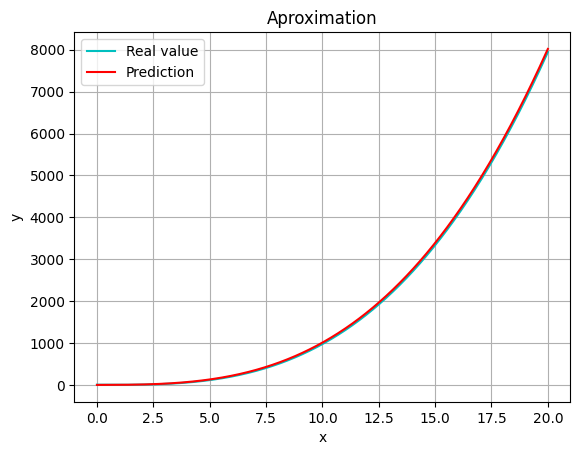

In [ ]:
plt.title("Aproximation")
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y, c='c')
plt.plot(x, test_aproximation(x, train_value), c='r')
plt.legend(['Real value', 'Prediction'])
plt.grid()
plt.show()